In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from datetime import datetime
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
#import os
#from google.colab import drive
#drive.mount('/content/gdrive')
#folder = '/content/gdrive/My Drive/Data ML Project'
#os.chdir(folder)
#print(torch.cuda.is_available())


In [3]:
daily = pd.read_csv("Targets/daily_crsp_sanitized.csv", nrows = 1000000)
daily['date'] = pd.to_datetime(daily['date'], format = "%Y-%m-%d")
daily = daily[daily['date'] >= '2000-01-31']
daily

,date,PERMCO,PERMNO,SICCD,NAICS,DlyRet,sprtrn
158482,2000-01-31,5,15580,6320,0,-0.068182,0.025218
158483,2000-01-31,7,14593,3573,0,0.020910,0.025218
158484,2000-01-31,25,62770,6711,0,0.041045,0.025218
158485,2000-01-31,29,59184,2082,0,0.011236,0.025218
158486,2000-01-31,33,59248,2082,0,0.034667,0.025218
...,...,...,...,...,...,...,...
999995,2000-06-23,9030,11183,3670,0,0.000000,-0.007368
999996,2000-06-23,9033,11185,7011,0,-0.030303,-0.007368
999997,2000-06-23,9036,11187,6330,0,-0.009901,-0.007368
999998,2000-06-23,9044,11194,3690,0,-0.026316,-0.007368


In [4]:
def prepare_data(daily, lagged_num=5, train_proportion = 0.75, rolling_window = False):

  #  Step 1: Prepare Data with lagged returns and categorical encoding

  # Sort and add lagged returns per PERMNO
  #daily = daily.sort_values(['PERMNO', 'date'])

  # Shift returns to create lagged features; keep NaNs for first few rows
  for i in range(lagged_num):
    daily[f'DlyRet_lag{i+1}'] = daily.groupby('PERMNO')['DlyRet'].shift(i+1)
    daily[f'DlyRet_lag{i+1}'] = daily[f'DlyRet_lag{i+1}'].fillna(daily[f'DlyRet_lag{i+1}'].mean())

  # Construct mean values overe rolling window of 10, 20 and 30 days
  if rolling_window == True:
    for i in range(3):
      daily[f'DlyRet_roll_{(i+1)*10}'] = daily.groupby('PERMNO')['DlyRet'].rolling(window = (i+1)*10).mean().fillna(0)

  # Encode categorical columns for embeddings
  for col in ['SICCD', 'NAICS']:
    daily[col] = daily[col].astype('category')
    daily[f'{col}_cat'] = daily[col].cat.codes

  # Feature lists
  features = [f'DlyRet_lag{i+1}' for i in range(lagged_num)]
  features.append('sprtrn')  # numeric
  cat_features = ['SICCD_cat', 'NAICS_cat']            # categorical (encoded)

  # Train/test split based on dates (chronological)
  unique_dates = np.sort(daily['date'].unique())
  n_train = int(len(unique_dates) * train_proportion)
  train_dates = unique_dates[:n_train]
  test_dates = unique_dates[n_train:]

  train_df = daily[daily['date'].isin(train_dates)].reset_index(drop=True)
  test_df = daily[daily['date'].isin(test_dates)].reset_index(drop=True)

  remove_columns = ['PERMCO', 'SICCD', 'NAICS']
  train_df = train_df.drop(remove_columns, axis=1)
  test_df = test_df.drop(remove_columns, axis=1)

  return train_df, test_df, features, cat_features


In [5]:
train_df, test_df, features, cat_features = prepare_data(daily)

In [6]:
test_df

,date,PERMNO,DlyRet,sprtrn,DlyRet_lag1,DlyRet_lag2,DlyRet_lag3,DlyRet_lag4,DlyRet_lag5,SICCD_cat,NAICS_cat
0,2000-05-18,15580,0.000000,-0.007315,-0.023256,0.023810,-0.011765,0.011905,-0.023256,785,0
1,2000-05-18,14593,-0.006165,-0.007315,-0.040804,0.046411,-0.061556,0.046809,0.035242,398,0
2,2000-05-18,62770,0.000000,-0.007315,0.014870,-0.007380,0.034351,-0.015038,0.076923,811,0
3,2000-05-18,59184,-0.003279,-0.007315,-0.009740,-0.005650,0.007317,-0.026128,0.025995,109,0
4,2000-05-18,59248,-0.007718,-0.007315,0.003319,0.002217,0.012346,-0.029412,0.032621,109,0
...,...,...,...,...,...,...,...,...,...,...,...
209499,2000-06-23,11183,0.000000,-0.007368,-0.019608,-0.056881,0.009259,0.038462,0.050505,441,0
209500,2000-06-23,11185,-0.030303,-0.007368,0.000000,0.000000,0.000000,0.000000,0.000000,829,0
209501,2000-06-23,11187,-0.009901,-0.007368,-0.004926,0.030457,-0.015000,0.015228,-0.015000,788,0
209502,2000-06-23,11194,-0.026316,-0.007368,0.000000,0.000000,0.000000,-0.037975,0.000000,449,0


In [7]:
train_df

,date,PERMNO,DlyRet,sprtrn,DlyRet_lag1,DlyRet_lag2,DlyRet_lag3,DlyRet_lag4,DlyRet_lag5,SICCD_cat,NAICS_cat
0,2000-01-31,15580,-0.068182,0.025218,0.000694,0.000687,0.000687,0.000677,0.000682,785,0
1,2000-01-31,14593,0.020910,0.025218,0.000694,0.000687,0.000687,0.000677,0.000682,398,0
2,2000-01-31,62770,0.041045,0.025218,0.000694,0.000687,0.000687,0.000677,0.000682,811,0
3,2000-01-31,59184,0.011236,0.025218,0.000694,0.000687,0.000687,0.000677,0.000682,109,0
4,2000-01-31,59248,0.034667,0.025218,0.000694,0.000687,0.000687,0.000677,0.000682,109,0
...,...,...,...,...,...,...,...,...,...,...,...
632009,2000-05-17,15912,-0.014286,-0.012442,0.014493,-0.014286,0.000000,-0.003268,-0.027397,817,0
632010,2000-05-17,79191,0.031496,-0.012442,0.042051,0.041667,0.083333,0.018868,-0.018519,43,0
632011,2000-05-17,78671,-0.045455,-0.012442,0.100000,0.012658,0.067568,-0.013333,0.000000,543,0
632012,2000-05-17,17337,0.000000,-0.012442,-0.019048,0.000000,-0.009434,-0.027523,-0.035398,315,0


In [8]:
# Dataset class
class FinancialDataset(Dataset):
    def __init__(self, df, features, cat_features, target_col='DlyRet'):
        self.X_num = df[features].values.astype(np.float32)
        self.X_cat = df[cat_features].values.astype(np.int64)
        self.y = df[target_col].values.astype(np.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X_num[idx], self.X_cat[idx], self.y[idx]



In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, dim, dropout_prob=0.3):  # add dropout param
        super().__init__()
        self.fc1 = nn.Linear(dim, dim)
        self.bn1 = nn.BatchNorm1d(dim)
        self.act1 = nn.LeakyReLU(0.1)
        self.dropout1 = nn.Dropout(dropout_prob)  # add dropout

        self.fc2 = nn.Linear(dim, dim)
        self.bn2 = nn.BatchNorm1d(dim)
        self.act2 = nn.LeakyReLU(0.1)
        self.dropout2 = nn.Dropout(dropout_prob)  # add dropout

    def forward(self, x):
        residual = x
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.act1(out)
        out = self.dropout1(out)  # apply dropout

        out = self.fc2(out)
        out = self.bn2(out)
        out += residual
        out = self.act2(out)
        out = self.dropout2(out)  # apply dropout
        return out


In [10]:
class ResidualMLP(nn.Module):
    def __init__(self, num_numeric_feats, cat_dims, embedding_dim=8, hidden_dim=64, n_blocks=3, dropout_prob=0.2):
        super().__init__()
        self.embeddings = nn.ModuleList([
            nn.Embedding(cat_dim, embedding_dim) for cat_dim in cat_dims
        ])

        input_dim = num_numeric_feats + embedding_dim * len(cat_dims)
        self.fc_in = nn.Linear(input_dim, hidden_dim)
        self.bn_in = nn.BatchNorm1d(hidden_dim)
        self.act_in = nn.LeakyReLU(0.1)
        self.dropout_in = nn.Dropout(dropout_prob)  # dropout after initial layer

        self.res_blocks = nn.Sequential(
            *[ResidualBlock(hidden_dim, dropout_prob) for _ in range(n_blocks)]
        )

        self.fc_out = nn.Linear(hidden_dim, 1)

    def forward(self, x_num, x_cat):
        embedded = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        x = torch.cat([x_num] + embedded, dim=1)

        x = self.fc_in(x)
        x = self.bn_in(x)
        x = self.act_in(x)
        x = self.dropout_in(x)  # dropout applied here

        x = self.res_blocks(x)
        out = self.fc_out(x).squeeze(-1)
        return out

In [11]:
def sharpe_ratio_loss(y_pred, y_true, eps=1e-6):
    port_returns = y_pred * y_true
    mean = port_returns.mean()
    std = port_returns.std()
    sharpe = mean / (std + eps)
    return -sharpe

In [12]:
# ---- Evaluation function ----
def evaluate_sharpe(model, loader, device=None):
    """Evaluate Sharpe ratio on a given data loader.

    Args:
        model: PyTorch model
        loader: DataLoader containing batches of (x_num, x_cat, y)
        device: Device to run computations on (default: model's device)

    Returns:
        Sharpe ratio (float)
    """
    if device is None:
        device = next(model.parameters()).device

    model.eval()
    all_preds = []
    all_y = []

    with torch.no_grad():
        for x_num, x_cat, y in loader:
            # Move data to the same device as model
            x_num = x_num.to(device)
            x_cat = x_cat.to(device)
            y = y.to(device)

            preds = model(x_num, x_cat)
            all_preds.append(preds)
            all_y.append(y)

    # Concatenate while keeping tensors on GPU
    preds = torch.cat(all_preds)
    y_true = torch.cat(all_y)

    # Compute portfolio returns on GPU
    port_returns = preds * y_true
    mean_ret = port_returns.mean()
    std_ret = port_returns.std()
    sharpe = (mean_ret / (std_ret + 1e-8)).item()  # Convert to Python float

    return sharpe

# Use only past 5 days of data

In [13]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import seaborn as sns
from tqdm import tqdm
import gc
import os
import numpy as np

# CPU-specific optimizations
torch.set_num_threads(os.cpu_count())  # Use all CPU cores
torch.set_num_interop_threads(os.cpu_count())  # Optimize inter-op parallelism

# Optimized batch sizes for CPU (smaller than GPU)
TRAIN_BATCH_SIZE = 2048  # Optimal for CPU memory bandwidth
TEST_BATCH_SIZE = 4096   # Larger for inference (no gradients)

# Use multiple workers for CPU data loading
NUM_WORKERS = min(os.cpu_count() // 2, 4)  # Don't oversaturate
print(f"Using {NUM_WORKERS} workers for data loading")
print(f"PyTorch using {torch.get_num_threads()} CPU threads")

# Create optimized data loaders for CPU
train_dataset = FinancialDataset(train_df, features, cat_features)
test_dataset = FinancialDataset(test_df, features, cat_features)

train_loader = DataLoader(
    train_dataset, 
    batch_size=TRAIN_BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS,
    pin_memory=False,  # No GPU transfer needed
    persistent_workers=True if NUM_WORKERS > 0 else False,
    prefetch_factor=2 if NUM_WORKERS > 0 else 2
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=TEST_BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS,
    pin_memory=False,
    persistent_workers=True if NUM_WORKERS > 0 else False,
    prefetch_factor=2 if NUM_WORKERS > 0 else 2
)

# Model setup for CPU
num_numeric_feats = len(features)
cat_dims = [daily[col].nunique() for col in cat_features]

device = torch.device("cpu")
print(f"Using device: {device}")

model = ResidualMLP(num_numeric_feats, cat_dims)
model = model.to(device)

# CPU-optimized optimizer
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=1e-3,  # Lower LR for smaller batches
    weight_decay=1e-4,
    eps=1e-8,
    fused=False  # Fused optimizer not available on CPU
)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max', 
    factor=0.7, 
    patience=7  # More patience for CPU training
)

def train_model_cpu_optimized(model, train_loader, test_loader, optimizer, scheduler, epochs=50):
    """
    CPU-optimized training with memory management and efficient evaluation
    """
    train_losses = []
    test_losses = []
    train_sharpes = []
    test_sharpes = []
    
    best_test_sharpe = float('-inf')
    
    # Pre-compile model for better CPU performance
    if hasattr(torch, 'compile'):
        try:
            model = torch.compile(model, mode='default')
            print("Model compiled for CPU optimization")
        except:
            print("Model compilation not available, using standard mode")
    
    for epoch in tqdm(range(epochs), desc="Training"):
        # Training phase
        model.train()
        total_loss = 0
        batch_count = 0
        
        # Use gradient accumulation for effective larger batch size
        accumulation_steps = 2
        optimizer.zero_grad()
        
        for batch_idx, (x_num, x_cat, y) in enumerate(train_loader):
            # Data is already on CPU
            x_num = x_num.to(device)
            x_cat = x_cat.to(device)
            y = y.to(device)
            
            # Forward pass
            outputs = model(x_num, x_cat)
            loss = sharpe_ratio_loss(outputs, y) / accumulation_steps
            
            # Backward pass
            loss.backward()
            
            # Update weights every accumulation_steps
            if (batch_idx + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
            
            total_loss += loss.item() * accumulation_steps
            batch_count += 1
            
            # Memory cleanup every 200 batches
            if batch_idx % 200 == 0:
                gc.collect()
        
        # Final optimizer step if needed
        if batch_count % accumulation_steps != 0:
            optimizer.step()
            optimizer.zero_grad()
        
        avg_loss = total_loss / batch_count
        train_losses.append(avg_loss)
        
        # Evaluation phase - less frequent for CPU efficiency
        if epoch % 3 == 0 or epoch == epochs - 1:
            # Test loss evaluation
            model.eval()
            total_test_loss = 0
            test_batch_count = 0
            
            with torch.no_grad():
                for x_num, x_cat, y in test_loader:
                    x_num = x_num.to(device)
                    x_cat = x_cat.to(device)
                    y = y.to(device)
                    
                    outputs = model(x_num, x_cat)
                    loss = sharpe_ratio_loss(outputs, y)
                    
                    total_test_loss += loss.item()
                    test_batch_count += 1
            
            avg_test_loss = total_test_loss / test_batch_count
            test_losses.append(avg_test_loss)
            
            # Sharpe evaluation with memory-efficient computation
            train_sharpe = evaluate_sharpe_cpu_optimized(model, train_loader, device)
            test_sharpe = evaluate_sharpe_cpu_optimized(model, test_loader, device)
            
            train_sharpes.append(train_sharpe)
            test_sharpes.append(test_sharpe)
            
            # Learning rate scheduling
            scheduler.step(test_sharpe)
            
            # Save best model
            if test_sharpe > best_test_sharpe:
                best_test_sharpe = test_sharpe
                torch.save(model.state_dict(), 'best_model_cpu.pth')
            
            print(f"Epoch {epoch+1}/{epochs}, "
                  f"Loss: {avg_loss:.4f}, "
                  f"Train Sharpe: {train_sharpe:.4f}, "
                  f"Test Sharpe: {test_sharpe:.4f}, "
                  f"LR: {optimizer.param_groups[0]['lr']:.6f}")
        else:
            # Fill in missing values for non-evaluation epochs
            if test_losses:
                test_losses.append(test_losses[-1])
                train_sharpes.append(train_sharpes[-1])
                test_sharpes.append(test_sharpes[-1])
        
        # Memory cleanup
        if epoch % 5 == 0:
            gc.collect()
    
    return train_losses, test_losses, train_sharpes, test_sharpes

def evaluate_sharpe_cpu_optimized(model, loader, device):
    """
    CPU-optimized Sharpe ratio evaluation with chunked processing
    """
    model.eval()
    
    # Use chunked processing to manage memory
    all_returns = []
    chunk_size = 10  # Process 10 batches at a time
    current_chunk = []
    
    with torch.no_grad():
        for batch_idx, (x_num, x_cat, y) in enumerate(loader):
            x_num = x_num.to(device)
            x_cat = x_cat.to(device)
            y = y.to(device)
            
            preds = model(x_num, x_cat)
            port_returns = preds * y
            
            current_chunk.append(port_returns)
            
            # Process chunk when full or at end
            if len(current_chunk) == chunk_size or batch_idx == len(loader) - 1:
                chunk_returns = torch.cat(current_chunk, dim=0)
                all_returns.append(chunk_returns.cpu().numpy())  # Move to CPU and numpy
                current_chunk = []
                
                # Clean up GPU memory
                del chunk_returns
                gc.collect()
    
    # Compute final statistics using numpy for efficiency
    all_returns = np.concatenate(all_returns)
    mean_ret = np.mean(all_returns)
    std_ret = np.std(all_returns)
    sharpe = mean_ret / (std_ret + 1e-8)
    
    return float(sharpe)

# Memory optimization before training
gc.collect()

# Run CPU-optimized training
print("Starting CPU-optimized training...")
print(f"Train batches: {len(train_loader)}, Test batches: {len(test_loader)}")
print(f"Batch sizes - Train: {TRAIN_BATCH_SIZE}, Test: {TEST_BATCH_SIZE}")
print(f"Effective batch size with accumulation: {TRAIN_BATCH_SIZE * 2}")

train_losses, test_losses, train_sharpes, test_sharpes = train_model_cpu_optimized(
    model, train_loader, test_loader, optimizer, scheduler, epochs=50
)

print("Training completed!")
print(f"Best test Sharpe ratio: {max(test_sharpes):.4f}")

# Final cleanup
gc.collect()

Using 4 workers for data loading
PyTorch using 16 CPU threads
Using device: cpu
Starting CPU-optimized training...
Train batches: 309, Test batches: 52
Batch sizes - Train: 2048, Test: 4096
Effective batch size with accumulation: 4096
Model compiled for CPU optimization


Training:   2%|▋                                 | 1/50 [00:49<40:39, 49.79s/it]

Epoch 1/50, Loss: -0.0138, Train Sharpe: 0.0329, Test Sharpe: 0.0114, LR: 0.001000


Training:   8%|██▋                               | 4/50 [01:24<14:12, 18.54s/it]

Epoch 4/50, Loss: -0.1171, Train Sharpe: 0.1419, Test Sharpe: 0.1110, LR: 0.001000


Training:  14%|████▊                             | 7/50 [01:58<10:16, 14.35s/it]

Epoch 7/50, Loss: -0.1429, Train Sharpe: 0.1558, Test Sharpe: 0.1258, LR: 0.001000


Training:  20%|██████▌                          | 10/50 [02:35<09:23, 14.08s/it]

Epoch 10/50, Loss: -0.1530, Train Sharpe: 0.1606, Test Sharpe: 0.1251, LR: 0.001000


Training:  26%|████████▌                        | 13/50 [03:09<08:24, 13.64s/it]

Epoch 13/50, Loss: -0.1595, Train Sharpe: 0.1667, Test Sharpe: 0.1416, LR: 0.001000


Training:  32%|██████████▌                      | 16/50 [03:46<07:53, 13.93s/it]

Epoch 16/50, Loss: -0.1649, Train Sharpe: 0.1788, Test Sharpe: 0.1445, LR: 0.001000


Training:  38%|████████████▌                    | 19/50 [04:21<07:00, 13.56s/it]

Epoch 19/50, Loss: -0.1698, Train Sharpe: 0.1824, Test Sharpe: 0.1495, LR: 0.001000


Training:  44%|██████████████▌                  | 22/50 [04:57<06:28, 13.87s/it]

Epoch 22/50, Loss: -0.1726, Train Sharpe: 0.1882, Test Sharpe: 0.1531, LR: 0.001000


Training:  50%|████████████████▌                | 25/50 [05:34<05:47, 13.92s/it]

Epoch 25/50, Loss: -0.1773, Train Sharpe: 0.1907, Test Sharpe: 0.1571, LR: 0.001000


Training:  56%|██████████████████▍              | 28/50 [06:13<05:20, 14.56s/it]

Epoch 28/50, Loss: -0.1803, Train Sharpe: 0.1941, Test Sharpe: 0.1581, LR: 0.001000


Training:  62%|████████████████████▍            | 31/50 [06:48<04:23, 13.88s/it]

Epoch 31/50, Loss: -0.1823, Train Sharpe: 0.1973, Test Sharpe: 0.1587, LR: 0.001000


Training:  68%|██████████████████████▍          | 34/50 [07:21<03:29, 13.12s/it]

Epoch 34/50, Loss: -0.1857, Train Sharpe: 0.1996, Test Sharpe: 0.1586, LR: 0.001000


Training:  74%|████████████████████████▍        | 37/50 [07:54<02:47, 12.89s/it]

Epoch 37/50, Loss: -0.1862, Train Sharpe: 0.2003, Test Sharpe: 0.1550, LR: 0.001000


Training:  80%|██████████████████████████▍      | 40/50 [08:30<02:15, 13.51s/it]

Epoch 40/50, Loss: -0.1897, Train Sharpe: 0.2042, Test Sharpe: 0.1575, LR: 0.001000


Training:  86%|████████████████████████████▍    | 43/50 [09:16<01:47, 15.41s/it]

Epoch 43/50, Loss: -0.1917, Train Sharpe: 0.2061, Test Sharpe: 0.1590, LR: 0.001000


Training:  92%|██████████████████████████████▎  | 46/50 [09:49<00:54, 13.73s/it]

Epoch 46/50, Loss: -0.1922, Train Sharpe: 0.2080, Test Sharpe: 0.1564, LR: 0.001000


Training:  98%|████████████████████████████████▎| 49/50 [10:22<00:12, 12.93s/it]

Epoch 49/50, Loss: -0.1942, Train Sharpe: 0.2086, Test Sharpe: 0.1605, LR: 0.001000


Training: 100%|█████████████████████████████████| 50/50 [10:42<00:00, 12.86s/it]

Epoch 50/50, Loss: -0.1955, Train Sharpe: 0.2110, Test Sharpe: 0.1594, LR: 0.001000
Training completed!
Best test Sharpe ratio: 0.1605


0

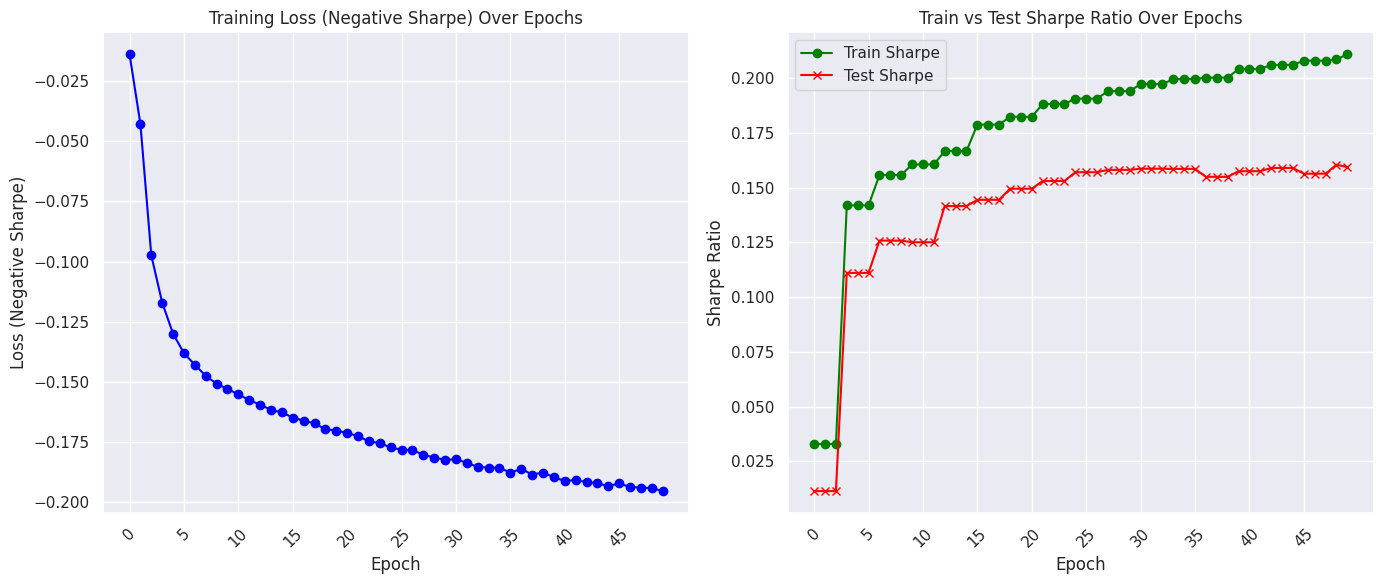

In [14]:
def plot_results_1(epochs, train_losses, train_sharpes, test_sharpes):
  # Plot results
  sns.set(style="darkgrid")
  plt.figure(figsize=(14, 6))

  # Plot loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, train_losses, marker='o', color='blue')
  plt.title('Training Loss (Negative Sharpe) Over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Loss (Negative Sharpe)')
  plt.xticks(ticks=range(0, 50, 5), rotation=45)  # Show ticks every 5 epochs, rotated

  # Plot Sharpe ratios
  plt.subplot(1, 2, 2)
  plt.plot(epochs, train_sharpes, label='Train Sharpe', marker='o', color='green')
  plt.plot(epochs, test_sharpes, label='Test Sharpe', marker='x', color='red')
  plt.title('Train vs Test Sharpe Ratio Over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Sharpe Ratio')
  plt.legend()
  plt.xticks(ticks=range(0, len(epochs), 5), rotation=45)  # Same here

  plt.tight_layout()
  plt.show()

plot_results_1(range(0, 50), train_losses, train_sharpes, test_sharpes)

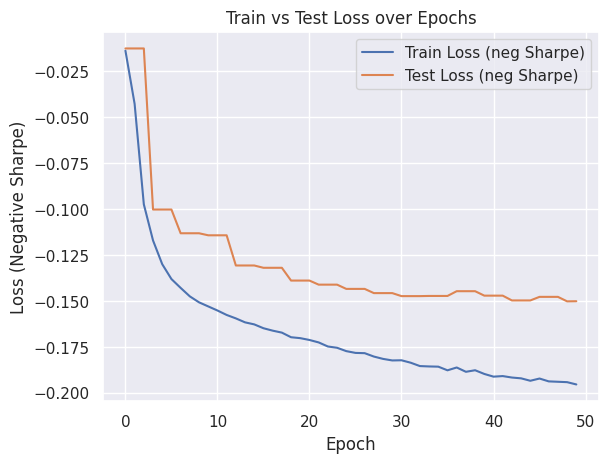

In [15]:
def plot_train_vs_test(epochs, train_losses, test_losses):
  plt.plot(epochs, train_losses, label='Train Loss (neg Sharpe)')
  plt.plot(epochs, test_losses, label='Test Loss (neg Sharpe)')
  plt.xlabel('Epoch')
  plt.ylabel('Loss (Negative Sharpe)')
  plt.title('Train vs Test Loss over Epochs')
  plt.legend()
  plt.grid(True)
  plt.show()

plot_train_vs_test(range(0, 50), train_losses, test_losses)

# Try importing and pre-processing firm characteristics

In [17]:
firms = pd.read_csv('Predictors/CompFirmCharac_sanitized.csv')
firms

,date,gvkey,acchgy,aolochy,aqcy,capxy,chechy,cibegniy,cicurry,cidergly,...,txbcoy,txdcy,txty,txwy,xidocy,xidoy,xinty,xiy,xopry,xsgay
0,2000-01-31,1013,0.0,-4.824,17.963,46.785,21.138,NaN,NaN,NaN,...,NaN,NaN,15.300,NaN,0.000,0.000,NaN,0.0,496.900,205.600
1,2000-01-31,1082,0.0,-1.734,0.000,9.597,-2.956,NaN,NaN,NaN,...,NaN,1.061,0.590,NaN,2.975,-2.563,4.084,0.0,123.541,6.468
2,2000-01-31,1173,0.0,0.882,0.000,0.558,-0.754,NaN,NaN,NaN,...,NaN,-0.073,0.222,NaN,0.000,0.000,0.416,0.0,21.847,7.457
3,2000-01-31,1183,0.0,-5.582,0.000,1.091,22.224,NaN,NaN,NaN,...,NaN,0.000,-3.286,NaN,0.741,0.741,NaN,0.0,9.732,NaN
4,2000-01-31,1189,0.0,-64.102,0.888,17.181,-12.630,NaN,NaN,NaN,...,NaN,6.349,12.136,NaN,-0.011,-0.007,8.095,0.0,724.161,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1159050,2025-03-31,323463,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1159051,2025-03-31,328087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1159052,2025-03-31,330942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1159053,2025-03-31,354003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import rankdata

def preprocess_characteristics(X_raw, missing_threshold=0.3):
    """
    Preprocess raw characteristics panel by date.
    
    Parameters:
    - X_raw: DataFrame with columns ['date', 'gvkey'] + 76 characteristics
    - missing_threshold: Max fraction of missing characteristics per stock
    
    Returns:
    - Dict of {date: processed_X} where each processed_X is (N_t x d)
    - Dict of {date: eligible_mask} indicating which stocks were kept
    """
    results = {}
    eligible_masks = {}
    
    # Group by date and process each month separately
    for date, group in X_raw.groupby('date'):
        # Extract characteristics (exclude date and gvkey columns)
        X_date = group.drop(columns=['date', 'gvkey'])
        
        # Filter stocks with <= 30% missing characteristics
        missing_frac = X_date.isna().mean(axis=1)
        eligible_mask = missing_frac <= missing_threshold
        X_eligible = X_date[eligible_mask].copy()
        
        # Rank-normalize each characteristic
        X_processed = pd.DataFrame(index=X_eligible.index, 
                                 columns=X_eligible.columns)
        
        for col in X_eligible.columns:
            x = X_eligible[col]
            non_missing = x.notna()
            x_non_missing = x[non_missing]
            
            if len(x_non_missing) > 0:
                ranks = rankdata(x_non_missing, method='average') - 1
                normalized = ranks / len(x_non_missing) - 0.5
                X_processed.loc[non_missing, col] = normalized
            
            X_processed.loc[~non_missing, col] = 0
        
        # Store results with original gvkeys
        X_processed['gvkey'] = group.loc[eligible_mask, 'gvkey'].values
        results[date] = X_processed
        eligible_masks[date] = eligible_mask
    
    return results, eligible_masks

def generate_random_features(X_processed_dict, P=None, gamma_grid=[0.5, 0.6, 0.7, 0.8, 0.9, 1.0], seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    G = len(gamma_grid)
    required_divisor = 2 * G
    
    if P is None:
        P = 12 * G
    elif P % required_divisor != 0:
        P = (P // required_divisor) * required_divisor
        print(f"Adjusted P to {P} to be divisible by {required_divisor}")
    
    P_per_gamma = P // G
    results = {}
    
    for date, X_processed in X_processed_dict.items():
        # Convert to numpy array and ensure float type
        X = np.asarray(X_processed.drop(columns=['gvkey']), dtype=np.float64)
        
        # Fill remaining NaNs with 0 (after preprocessing should be none)
        X = np.nan_to_num(X)
        
        N_t, d = X.shape
        S_hat_parts = []
        
        for gamma in gamma_grid:
            W_g = np.random.normal(0, gamma, size=(d, P_per_gamma // 2))
            XW = X @ W_g
            
            # Debug check
            if np.any(np.isnan(XW)):
                print(f"Warning: NaNs detected in XW for date {date}")
                XW = np.nan_to_num(XW)
            
            S_g = np.concatenate([np.cos(XW), np.sin(XW)], axis=1)
            S_hat_parts.append(S_g)
        
        S_hat = np.concatenate(S_hat_parts, axis=1)
        perm = np.random.permutation(S_hat.shape[1])
        S_hat = S_hat[:, perm]
        
        S = (rankdata(S_hat, axis=0, method='average') - 1) / N_t - 0.5
        result_df = pd.DataFrame(S, index=X_processed['gvkey'])
        results[date] = (S_hat, result_df)
    
    return results

    
def compute_random_factors(S_dict, returns_df):
    """
    Compute random factors for each date.
    
    Parameters:
    - S_dict: Dict of {date: S} from generate_random_features
    - returns_df: DataFrame with columns ['date', 'gvkey', 'ret']
    
    Returns:
    - DataFrame of factors indexed by date
    """
    factors = []
    
    for date, (_, S_df) in S_dict.items():
        # Get next month's returns for these gvkeys
        next_date = pd.to_datetime(date) + pd.offsets.MonthEnd(1)
        next_returns = returns_df[
            (returns_df['date'] == next_date) & 
            (returns_df['gvkey'].isin(S_df.index))
        ]
        
        if not next_returns.empty:
            # Align returns with features
            merged = S_df.merge(next_returns, left_index=True, right_on='gvkey')
            R_next = merged['ret'].values
            S = merged.drop(columns=['date', 'gvkey', 'ret']).values
            
            N_t = S.shape[0]
            F = (R_next.T @ S) / np.sqrt(N_t)
            
            factors.append(pd.Series(F, name=date))
    
    return pd.DataFrame(factors)

# Example usage:
#if __name__ == "__main__":
    # Assuming:
    # X_raw: DataFrame with ['date', 'gvkey'] + 76 characteristics
    # returns_df: DataFrame with ['date', 'gvkey', 'ret']
    
    # Step 1: Preprocess by date
X_processed_dict, eligible_masks = preprocess_characteristics(firms)
    
    # Step 2: Generate random features
P = 1000
random_features_dict = generate_random_features(X_processed_dict, P, seed=42)
    
    # Step 3: Compute factors
factors_df = compute_random_factors(random_features_dict, returns_df)
print(f"Generated factors for {len(factors_df)} months")
factors_df

Adjusted P to 996 to be divisible by 12
